In [1]:
# --- 1. Setup ---
import os
%pip install nltk -- quiet
import nltk
%pip install transformers torch --quiet
from nltk import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

%pip install pandas matplotlib --quiet
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

# Download required NLTK data
nltk.download("punkt")
nltk.download("vader_lexicon")

# Paths
input_dir = "../data/chapters"

# Tools
sia = SentimentIntensityAnalyzer()
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Users\drawn\Documents\KafkaNLP\kafka_trial_analysis\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\drawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\drawn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Device set to use cpu


In [2]:
import re

def chapter_number(filename):
    # Extract first number from filename (e.g., "chapter_10_nostopwords.txt" -> 10)
    match = re.search(r"(\d+)", filename)
    return int(match.group(1)) if match else 0

files = sorted(
    [f for f in os.listdir(input_dir) if f.endswith(".txt")],
    key=chapter_number
)


In [3]:
nltk.download("punkt")
nltk.download("punkt_tab")
vader_results = []

for filename in sorted(files):
    if filename.endswith(".txt"):
        with open(os.path.join(input_dir, filename), "r", encoding="utf-8") as f:
            text = f.read()

        sentences = sent_tokenize(text)
        scores = [sia.polarity_scores(s)["compound"] for s in sentences]
        avg_score = sum(scores) / len(scores) if scores else 0

        vader_results.append({
            "chapter": filename,
            "vader_avg": avg_score,
            "vader_min": min(scores, default=0),
            "vader_max": max(scores, default=0)
        })

df_vader = pd.DataFrame(vader_results)
df_vader

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\drawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\drawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,chapter,vader_avg,vader_min,vader_max
0,chapter_1.txt,0.059989,-0.9013,0.9569
1,chapter_10.txt,0.041452,-0.8316,0.8020
2,chapter_2.txt,0.049977,-0.8625,0.9153
3,chapter_3.txt,0.066927,-0.9250,0.9578
4,chapter_4.txt,0.005946,-0.8318,0.8779
5,chapter_5.txt,-0.064588,-0.8491,0.9593
6,chapter_6.txt,0.070093,-0.8886,0.9201
7,chapter_7.txt,0.079300,-0.9258,0.9574
8,chapter_8.txt,0.018323,-0.9037,0.9169
9,chapter_9.txt,0.013494,-0.9350,0.9459


In [4]:
hf_results = []

for filename in sorted(files):
    if filename.endswith(".txt"):
        with open(os.path.join(input_dir, filename), "r", encoding="utf-8") as f:
            text = f.read()

        # Transformer models have a max input length (~512 tokens), so we chunk
        chunks = [text[i:i+1000] for i in range(0, len(text), 1000)]
        chunk_scores = []

        for chunk in chunks:
            result = classifier(chunk)[0]  # {'label': 'POSITIVE', 'score': 0.99}
            score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
            chunk_scores.append(score)

        avg_score = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0

        hf_results.append({
            "chapter": filename,
            "hf_avg": avg_score,
            "hf_min": min(chunk_scores, default=0),
            "hf_max": max(chunk_scores, default=0)
        })

df_hf = pd.DataFrame(hf_results)
df_hf

,chapter,hf_avg,hf_min,hf_max
0,chapter_1.txt,-0.604823,-0.999638,0.998998
1,chapter_10.txt,-0.643897,-0.999363,0.946544
2,chapter_2.txt,-0.714444,-0.999390,0.992278
3,chapter_3.txt,-0.705804,-0.999510,0.998548
4,chapter_4.txt,-0.720554,-0.999235,0.989793
5,chapter_5.txt,-0.978146,-0.999213,-0.786525
6,chapter_6.txt,-0.599229,-0.998703,0.985418
7,chapter_7.txt,-0.655878,-0.999666,0.997402
8,chapter_8.txt,-0.641857,-0.999558,0.998966
9,chapter_9.txt,-0.653575,-0.999209,0.990889


In [5]:
df = pd.merge(df_vader, df_hf, on="chapter")

df["chapter_num"] = df["chapter"].apply(chapter_number)
df = df.sort_values("chapter_num")

df

,chapter,vader_avg,vader_min,vader_max,hf_avg,hf_min,hf_max,chapter_num
0,chapter_1.txt,0.059989,-0.9013,0.9569,-0.604823,-0.999638,0.998998,1
2,chapter_2.txt,0.049977,-0.8625,0.9153,-0.714444,-0.999390,0.992278,2
3,chapter_3.txt,0.066927,-0.9250,0.9578,-0.705804,-0.999510,0.998548,3
4,chapter_4.txt,0.005946,-0.8318,0.8779,-0.720554,-0.999235,0.989793,4
5,chapter_5.txt,-0.064588,-0.8491,0.9593,-0.978146,-0.999213,-0.786525,5
6,chapter_6.txt,0.070093,-0.8886,0.9201,-0.599229,-0.998703,0.985418,6
7,chapter_7.txt,0.079300,-0.9258,0.9574,-0.655878,-0.999666,0.997402,7
8,chapter_8.txt,0.018323,-0.9037,0.9169,-0.641857,-0.999558,0.998966,8
9,chapter_9.txt,0.013494,-0.9350,0.9459,-0.653575,-0.999209,0.990889,9
1,chapter_10.txt,0.041452,-0.8316,0.8020,-0.643897,-0.999363,0.946544,10


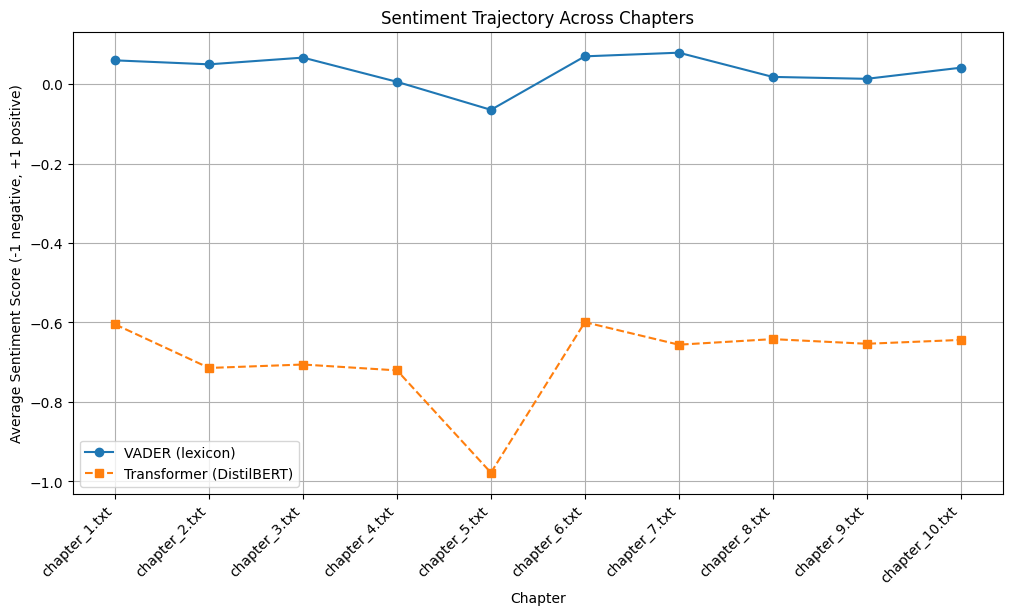

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df["chapter_num"], df["vader_avg"], marker="o", label="VADER (lexicon)")
plt.plot(df["chapter_num"], df["hf_avg"], marker="s", linestyle="--", label="Transformer (DistilBERT)")
plt.xticks(df["chapter_num"], df["chapter"], rotation=45, ha="right")
plt.title("Sentiment Trajectory Across Chapters")
plt.xlabel("Chapter")
plt.ylabel("Average Sentiment Score (-1 negative, +1 positive)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import numpy as np

hf_dist_results = []

for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".txt"):
        with open(os.path.join(input_dir, filename), "r", encoding="utf-8") as f:
            text = f.read()

        # Chunk text (transformer input length limit)
        chunks = [text[i:i+1000] for i in range(0, len(text), 1000)]
        pos_count, neg_count = 0, 0

        for chunk in chunks:
            result = classifier(chunk)[0]  # {'label': 'POSITIVE', 'score': 0.99}
            if result["label"] == "POSITIVE":
                pos_count += 1
            else:
                neg_count += 1

        total = pos_count + neg_count
        pos_ratio = pos_count / total if total > 0 else 0
        neg_ratio = neg_count / total if total > 0 else 0

        hf_dist_results.append({
            "chapter": filename,
            "positive_ratio": pos_ratio,
            "negative_ratio": neg_ratio
        })

df_hf_dist = pd.DataFrame(hf_dist_results)
df_hf_dist

,chapter,positive_ratio,negative_ratio
0,chapter_1.txt,0.200000,0.800000
1,chapter_10.txt,0.166667,0.833333
2,chapter_2.txt,0.142857,0.857143
3,chapter_3.txt,0.140000,0.860000
4,chapter_4.txt,0.125000,0.875000
5,chapter_5.txt,0.000000,1.000000
6,chapter_6.txt,0.181818,0.818182
7,chapter_7.txt,0.166667,0.833333
8,chapter_8.txt,0.187500,0.812500
9,chapter_9.txt,0.163265,0.836735


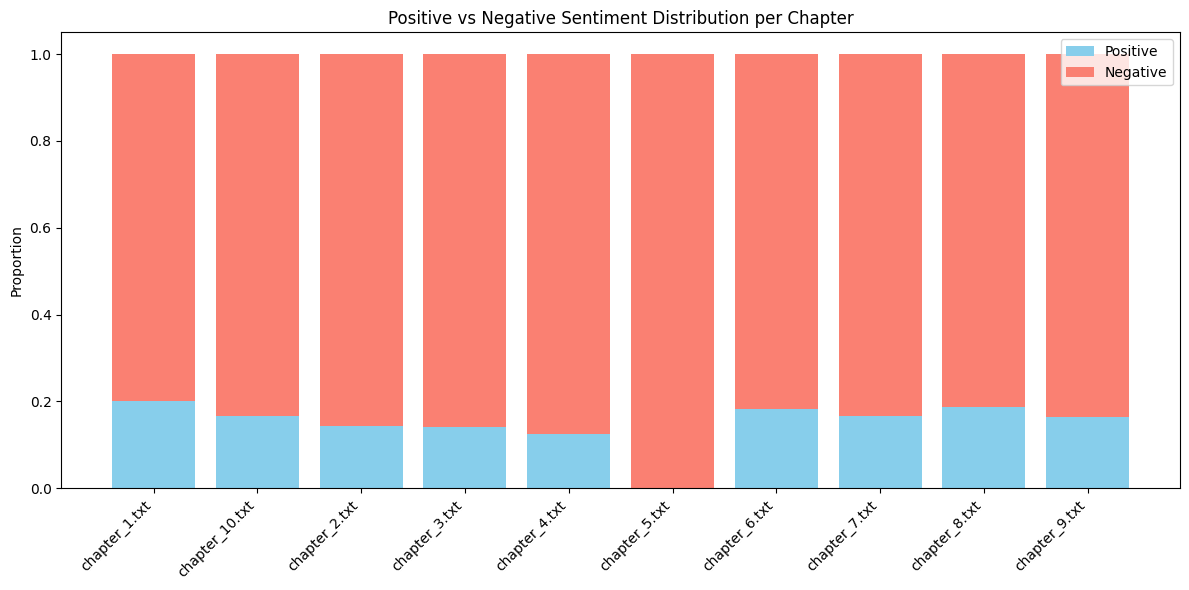

In [8]:
chapters = df_hf_dist["chapter"]
pos_vals = df_hf_dist["positive_ratio"]
neg_vals = df_hf_dist["negative_ratio"]

plt.figure(figsize=(12,6))
plt.bar(chapters, pos_vals, label="Positive", color="skyblue")
plt.bar(chapters, neg_vals, bottom=pos_vals, label="Negative", color="salmon")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion")
plt.title("Positive vs Negative Sentiment Distribution per Chapter")
plt.legend()
plt.tight_layout()
plt.show()
